In [ ]:
# Setup - Run only once per Kernel App
%pip install https://anaconda.org/conda-forge/openjdk/11.0.1/download/linux-64/openjdk-11.0.1-hacce0ff_1021.tar.bz2

# install PySpark
%pip install pyspark==3.4.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.5/180.5 MB 6.0 MB/s eta 0:00:00
ERROR: https://anaconda.org/conda-forge/openjdk/11.0.1/download/linux-64/openjdk-11.0.1-hacce0ff_1021.tar.bz2 does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317123 sha256=d9b2403fda9940eb37ecd960fef35f594156148ee39d6b9da8643aad71c06ea4
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.3
    Uninstalling pyspark-3.5.3:
      Successfully uninstalled pyspark-3.5.3


In [ ]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

3.4.0


In [ ]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder \
    .appName("Insurance Data Analysis") \
    .getOrCreate()

# Read the CSV file with semicolon delimiter
df_spark = spark.read \
    .option("delimiter", ";") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv('Motor vehicle insurance data.csv')

# Show the schema and first few rows
df_spark.printSchema()
df_spark.show(5)

root
 |-- ID: integer (nullable = true)
 |-- Date_start_contract: string (nullable = true)
 |-- Date_last_renewal: string (nullable = true)
 |-- Date_next_renewal: string (nullable = true)
 |-- Date_birth: string (nullable = true)
 |-- Date_driving_licence: string (nullable = true)
 |-- Distribution_channel: string (nullable = true)
 |-- Seniority: integer (nullable = true)
 |-- Policies_in_force: integer (nullable = true)
 |-- Max_policies: integer (nullable = true)
 |-- Max_products: integer (nullable = true)
 |-- Lapse: integer (nullable = true)
 |-- Date_lapse: string (nullable = true)
 |-- Payment: integer (nullable = true)
 |-- Premium: double (nullable = true)
 |-- Cost_claims_year: double (nullable = true)
 |-- N_claims_year: integer (nullable = true)
 |-- N_claims_history: integer (nullable = true)
 |-- R_Claims_history: double (nullable = true)
 |-- Type_risk: integer (nullable = true)
 |-- Area: integer (nullable = true)
 |-- Second_driver: integer (nullable = true)
 |-- Yea

## Exploratory Data Analysis

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Helper function to count null values
def count_nulls(df):
    return df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])

# Helper function to get basic statistics
def get_basic_stats(df, column):
    return df.select(
        F.count(column).alias('count'),
        F.mean(column).alias('mean'),
        F.min(column).alias('min'),
        F.max(column).alias('max')
    ).collect()[0]

In [ ]:
# Get row count
row_count = df_spark.count()
print(f"Total number of rows: {row_count}")

# Get null counts
null_counts = count_nulls(df_spark)
null_counts.show()

Total number of rows: 105555
+---+-------------------+-----------------+-----------------+----------+--------------------+--------------------+---------+-----------------+------------+------------+-----+----------+-------+-------+----------------+-------------+----------------+----------------+---------+----+-------------+------------------+-----+-----------------+-------------+-------+---------+------+------+
| ID|Date_start_contract|Date_last_renewal|Date_next_renewal|Date_birth|Date_driving_licence|Distribution_channel|Seniority|Policies_in_force|Max_policies|Max_products|Lapse|Date_lapse|Payment|Premium|Cost_claims_year|N_claims_year|N_claims_history|R_Claims_history|Type_risk|Area|Second_driver|Year_matriculation|Power|Cylinder_capacity|Value_vehicle|N_doors|Type_fuel|Length|Weight|
+---+-------------------+-----------------+-----------------+----------+--------------------+--------------------+---------+-----------------+------------+------------+-----+----------+-------+-------+

In [ ]:
# Basic statistics for numerical columns
numeric_cols = [field.name for field in df_spark.schema.fields
                if field.dataType.typeName() in ['double', 'integer']]

for col in numeric_cols:
    print(f"\nStatistics for {col}:")
    df_spark.select(col).summary().show()


Statistics for ID:
+-------+------------------+
|summary|                ID|
+-------+------------------+
|  count|            105555|
|   mean|26271.286788877835|
| stddev|15388.309324237242|
|    min|                 1|
|    25%|             12925|
|    50%|             26081|
|    75%|             39756|
|    max|             53502|
+-------+------------------+


Statistics for Seniority:
+-------+------------------+
|summary|         Seniority|
+-------+------------------+
|  count|            105555|
|   mean| 6.696603666335086|
| stddev|6.2639114990010345|
|    min|                 1|
|    25%|                 3|
|    50%|                 4|
|    75%|                 9|
|    max|                40|
+-------+------------------+


Statistics for Policies_in_force:
+-------+------------------+
|summary| Policies_in_force|
+-------+------------------+
|  count|            105555|
|   mean|1.4556487139405996|
| stddev|0.9284271605171871|
|    min|                 1|
|    25%|        

#### 1. Distribution of Premium

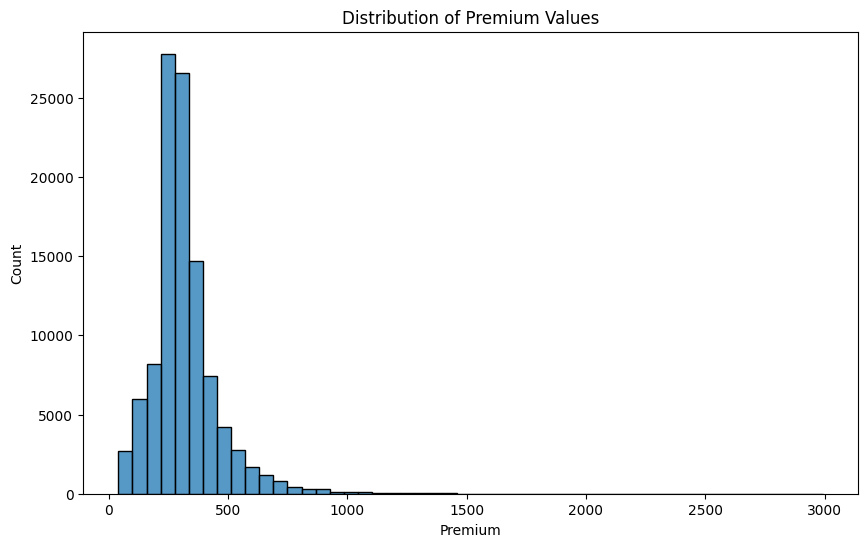

In [ ]:
# 1. Distribution of Premium
premium_pd = df_spark.select('Premium').toPandas()
plt.figure(figsize=(10, 6))
sns.histplot(data=premium_pd, x='Premium', bins=50)
plt.title('Distribution of Premium Values')
plt.xlabel('Premium')
plt.ylabel('Count')
plt.show()

#### 2. Premium vs Vehicle Value

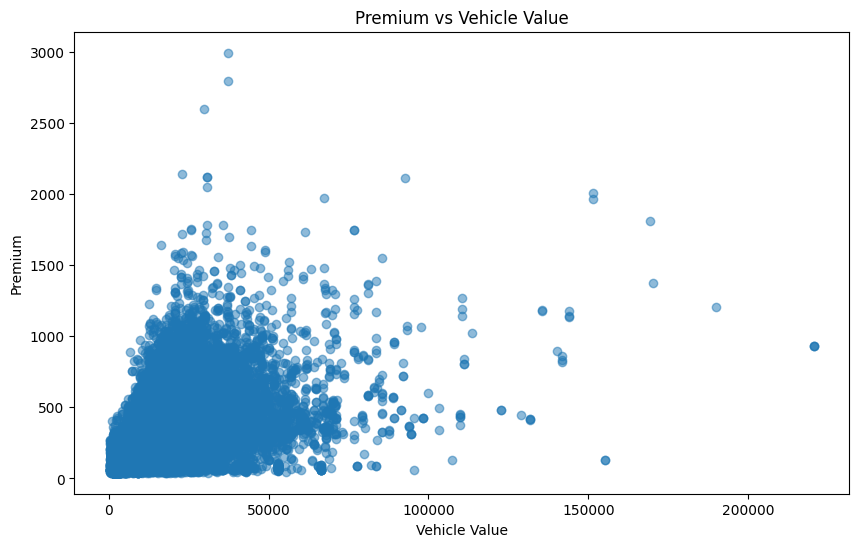

In [ ]:
# 2. Premium vs Vehicle Value
premium_value = df_spark.select('Premium', 'Value_vehicle').toPandas()
plt.figure(figsize=(10, 6))
plt.scatter(premium_value['Value_vehicle'], premium_value['Premium'], alpha=0.5)
plt.title('Premium vs Vehicle Value')
plt.xlabel('Vehicle Value')
plt.ylabel('Premium')
plt.show()

#### 3. Distribution Channel Analysis

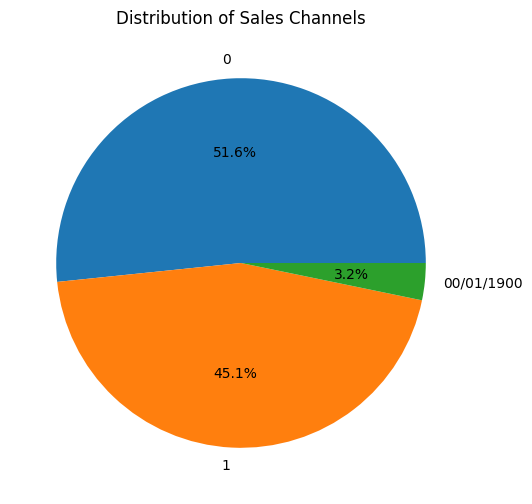

In [ ]:
# 3. Distribution Channel Analysis
channel_dist = df_spark.groupBy('Distribution_channel') \
    .count() \
    .orderBy(F.desc('count')) \
    .toPandas()

plt.figure(figsize=(10, 6))
plt.pie(channel_dist['count'], labels=channel_dist['Distribution_channel'], autopct='%1.1f%%')
plt.title('Distribution of Sales Channels')
plt.show()

In [ ]:
# 1. Customer Age and Experience
df_transformed = df_spark.withColumn(
    'customer_age',
    F.year(F.current_date()) - F.year(F.to_date('Date_birth', 'dd/MM/yyyy'))
).withColumn(
    'driving_experience',
    F.year(F.current_date()) - F.year(F.to_date('Date_driving_licence', 'dd/MM/yyyy'))
).withColumn(
    'vehicle_age',
    F.year(F.current_date()) - F.col('Year_matriculation')
)


df_transformed = df_transformed.withColumn(
    'risk_score',
    (F.col('N_claims_history') * 10 +
     F.col('Power') / 50 +
     F.col('Value_vehicle') / 10000 +
     F.col('R_Claims_history') * 5)
)

# 3. Customer Value (combination of premium, policies in force, and seniority)
df_transformed = df_transformed.withColumn(
    'customer_value',
    (F.col('Premium') * F.col('Policies_in_force') *
     (1 + F.col('Seniority') / 10))
)

#### Table 1: Risk Profile Analysis by Age Group

In [ ]:
risk_by_age = df_transformed.withColumn(
    'age_group',
    F.when(F.col('customer_age') < 25, '18-24')
    .when(F.col('customer_age').between(25, 35), '25-35')
    .when(F.col('customer_age').between(36, 50), '36-50')
    .when(F.col('customer_age').between(51, 65), '51-65')
    .otherwise('65+')
).groupBy('age_group').agg(
    F.round(F.avg('Premium'), 2).alias('avg_premium'),
    F.round(F.avg('risk_score'), 2).alias('avg_risk_score'),
    F.count('*').alias('number_of_policies'),
    F.round(F.avg('N_claims_history'), 2).alias('avg_claims_history'),
    F.round(F.avg('Value_vehicle'), 2).alias('avg_vehicle_value')
).orderBy('age_group')

print("Risk Profile Analysis by Age Group:")
risk_by_age.show()

Risk Profile Analysis by Age Group:
+---------+-----------+--------------+------------------+------------------+-----------------+
|age_group|avg_premium|avg_risk_score|number_of_policies|avg_claims_history|avg_vehicle_value|
+---------+-----------+--------------+------------------+------------------+-----------------+
|    18-24|     451.47|          9.02|                11|              0.55|         18540.33|
|    25-35|     396.46|         24.61|              6443|              1.84|         17016.86|
|    36-50|     314.61|         32.99|             37342|               2.7|         18877.22|
|    51-65|     315.27|          34.5|             40244|              2.87|         18357.35|
|      65+|     295.08|         34.41|             21515|              2.91|         18132.64|
+---------+-----------+--------------+------------------+------------------+-----------------+



#### Table 2: Vehicle Analysis by Type and Age

In [ ]:
vehicle_analysis = df_transformed.groupBy('Type_fuel', 'Type_risk').agg(
    F.count('*').alias('vehicle_count'),
    F.round(F.avg('vehicle_age'), 2).alias('avg_vehicle_age'),
    F.round(F.avg('Premium'), 2).alias('avg_premium'),
    F.round(F.avg('Power'), 2).alias('avg_power'),
    F.round(F.avg('Value_vehicle'), 2).alias('avg_value')
).orderBy('Type_fuel', 'Type_risk')

print("\nVehicle Analysis by Type and Age:")
vehicle_analysis.show()


Vehicle Analysis by Type and Age:
+---------+---------+-------------+---------------+-----------+---------+---------+
|Type_fuel|Type_risk|vehicle_count|avg_vehicle_age|avg_premium|avg_power|avg_value|
+---------+---------+-------------+---------------+-----------+---------+---------+
|        D|        1|           31|          28.32|     141.95|    55.06|   3656.3|
|        D|        2|        12499|          19.57|     330.35|    93.37| 20038.75|
|        D|        3|        51750|          18.32|      342.6|    103.7| 21260.25|
|        D|        4|          718|          28.93|      79.22|     74.3| 35246.08|
|       NA|        1|         1645|          34.44|     147.52|      0.0|  4053.52|
|       NA|        4|          119|          37.31|      81.77|      0.0| 36744.88|
|        P|        1|         6826|          20.05|     142.99|    25.79|  4146.71|
|        P|        2|          713|          21.87|     291.77|    88.14|  16478.6|
|        P|        3|        31240|      

#### Table 3: Customer Segments Analysis

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
window_spec = Window.orderBy('customer_value')
customer_segments = df_transformed.withColumn(
    'percentile', F.percent_rank().over(window_spec)
).withColumn(
    'customer_segment',
    F.when(F.col('percentile') < 0.2, 'Bronze')
    .when(F.col('percentile') < 0.5, 'Silver')
    .when(F.col('percentile') < 0.8, 'Gold')
    .otherwise('Platinum')
).groupBy('customer_segment').agg(
    F.count('*').alias('customer_count'),
    F.round(F.avg('Premium'), 2).alias('avg_premium'),
    F.round(F.avg('Policies_in_force'), 2).alias('avg_policies'),
    F.round(F.avg('customer_value'), 2).alias('avg_customer_value'),
    F.round(F.sum('Premium'), 2).alias('total_premium_revenue')
).orderBy('customer_segment')

print("\nCustomer Segments Analysis:")
customer_segments.show()


Customer Segments Analysis:
+----------------+--------------+-----------+------------+------------------+---------------------+
|customer_segment|customer_count|avg_premium|avg_policies|avg_customer_value|total_premium_revenue|
+----------------+--------------+-----------+------------+------------------+---------------------+
|          Bronze|         21114|     205.13|        1.09|            269.66|           4331136.59|
|            Gold|         31667|     343.33|         1.4|            724.09|        1.087227778E7|
|        Platinum|         21111|     409.25|        2.45|           1712.14|           8639660.45|
|          Silver|         31663|     300.07|        1.09|            444.38|           9500964.06|
+----------------+--------------+-----------+------------+------------------+---------------------+



#### Correlations between new variables

In [ ]:
def analyze_new_variables(df):
    return df.select(
        F.corr('risk_score', 'Premium').alias('risk_score_premium_correlation'),
        F.corr('customer_value', 'N_claims_history').alias('value_claims_correlation'),
        F.corr('driving_experience', 'risk_score').alias('experience_risk_correlation')
    )

correlations = analyze_new_variables(df_transformed)
print("\nCorrelations between new variables:")
correlations.show()


Correlations between new variables:
+------------------------------+------------------------+---------------------------+
|risk_score_premium_correlation|value_claims_correlation|experience_risk_correlation|
+------------------------------+------------------------+---------------------------+
|           0.14490940841449382|       0.442514828905576|        0.05429202429152049|
+------------------------------+------------------------+---------------------------+

